In [1]:
# restart the kernel to clear past work
# (can also do this manually from the Kernel options above)
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import sys
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# homemade source code from source folder
sys.path.append('../source')
from core.grid import Grid
from core.rhsevolution import *
from core.spacing import *
from core.display import *
from core.statevector import *
from matter.scalarmatter import *
from initialdata.choptuik import *
from backgrounds.sphericalbackground import *
from bssn.constraintsdiagnostic import *
from bssn.ahfinder import *



#from bssn.bssnvars import BSSNVars
#from bssn.bssnstatevariables import NUM_BSSN_VARS

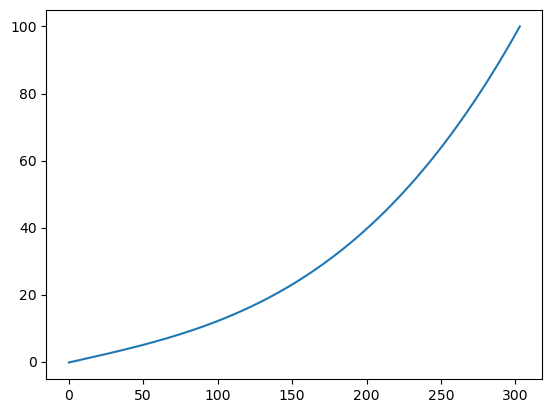

Grid: 304 punti, NUM_VARS=14


In [3]:

# 1) Parametri dominio e spacing cubico
r_max, min_dr, max_dr = 100.0, 0.1, 0.80
params = CubicSpacing.get_parameters(r_max, min_dr, max_dr)

# 2) Crea prima materia e state
matter = ScalarMatter()
state  = StateVector(matter)

# 3) Ora costruisci la griglia passando lo state
grid   = Grid(CubicSpacing(**params), state)
# Evita r=0 per il check del determinante in BSSN
#grid.r[0] = grid.r[1]

# 4) Background
bg     = FlatSphericalBackground(grid.r)
plt.plot(grid.r, "-")
plt.show()
#bssn_vars = BSSNVars(NUM_BSSN_VARS)

#prova = matter.get_emtensor(grid.r, bssn_vars, bg).rho
#plt.plot(grid.r, prova, "-")
#plt.show()
r = grid.r
num_points = r.size
print(f"Grid: {grid.num_points} punti, NUM_VARS={state.NUM_VARS}")

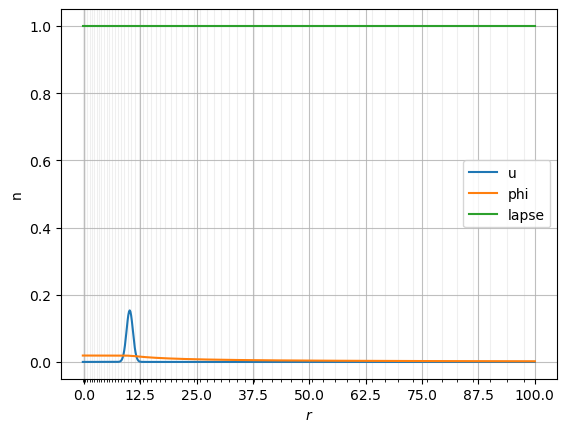

u.min(), u.max()  = 0.0 0.15336264292491214
prime 5 voci u: [0. 0. 0. 0. 0.]


In [4]:
initial_state = get_initial_state(grid, bg)

#unpackage the vector for readability
(initial_phi, initial_hrr, initial_htt, initial_hpp, 
 initial_K, initial_arr, initial_att, initial_app, 
 initial_lambdar, initial_shiftr, initial_br, initial_lapse,
 initial_u, initial_v) = np.array_split(initial_state, grid.NUM_VARS)

#initial_state[matter.idx_v, :] = 0.0

#plot initial conditions
plt.xlabel('r')
plt.ylabel('n')
plt.plot(r, initial_u, '-', label='u') # zero, but plot as dots to see the grid
#plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
#plt.plot(r, initial_hrr, label='hrr')
#plt.plot(r, initial_hpp, label='hpp')
#plt.plot(r, initial_htt, label='htt')
#plt.plot(r, initial_arr, label='arr')
#plt.plot(r, initial_lambdar, label='lambdar')
#plt.plot(r, initial_shiftr, label='shiftr')
plt.plot(r, initial_lapse, label='lapse')
plt.legend(loc='best')
ax = plt.gcf().gca()
set_grid_on_ax(ax, r)
#plt.xlim(0.00,15.0)
#plt.ylim(-0.6,1.50)
plt.show()
#import inspect
#print(inspect.getsource(get_initial_state))

print("u.min(), u.max()  =", initial_u.min(), initial_u.max())
print("prime 5 voci u:", initial_u[:5])

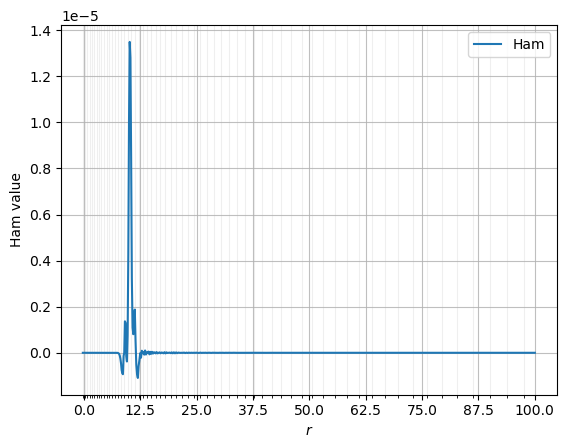

In [5]:
#initial_state = get_initial_state(grid, bg)
# check the Hamiltonian constraint initially satisfied
# apart from numerical errors
Ham, Mom = get_constraints_diagnostic(initial_state, np.array([0]), grid, bg, matter)

# plot the profile for Ham
plt.plot(r, Ham[0], label="Ham")
#plt.plot(r, Mom[0], label="Mom")

plt.xlabel('r')
plt.legend(loc="best")

#plt.ylim(-0.1,0.1)
plt.ylabel('Ham value')
ax = plt.gcf().gca()
set_grid_on_ax(ax, r)
#plt.xlim(0 ,15)
#plt.ylim(-0.1, 0.1)
#plt.xlim(0.0,11.0)

plt.show()

In [6]:
# for control of time integrator and spatial grid
T = 20.0 # Maximum evolution time
num_points_t = 101 # time resolution (only for outputs, not for integration)

# Work out dt and time spacing of outputs
dt = T/num_points_t
t = np.linspace(0.1, T-dt, num_points_t)

# Solve for the solution using RK45 integration of the ODE
# to make like (older) python odeint method use method='LSODA' instead BDF
# use tqdm package to track progress
with tqdm(total=1000, unit="‰") as progress_bar:
    dense_solution = solve_ivp(get_rhs, [0,T], initial_state, 
                               args=(grid, bg, matter, progress_bar, [0, T/1000]),
                        atol=1e-6, rtol=1e-6,
                        max_step = 0.25 * min_dr, #for stability and for KO coeff of 1
                        method='RK45', dense_output=True)

# Interpolate the solution at the time points defined in myparams.py
solution = dense_solution.sol(t).T

  0%|          | 0/1000 [00:00<?, ?‰/s]

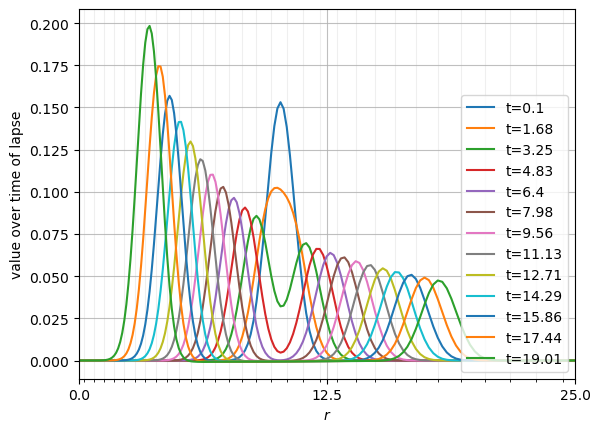

In [7]:
# plot the profile for some variable at a selection of times
var = matter.idx_u # I suggest looking at the field u, or the lapse to see the gauge evolution
var3 = idx_phi
var2 = idx_lapse

for i, t_i in enumerate(t) :
    if (i < num_points_t) and (i %8 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * num_points: (var + 1) * num_points]
        plt.plot(r, f_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.ylabel('value over time of ' + state.VARIABLE_NAMES[var2])
ax = plt.gcf().gca()
set_grid_on_ax(ax, r)
plt.xlim(0.0,25.0)
#plt.ylim(-0.1,0.1)
plt.show()

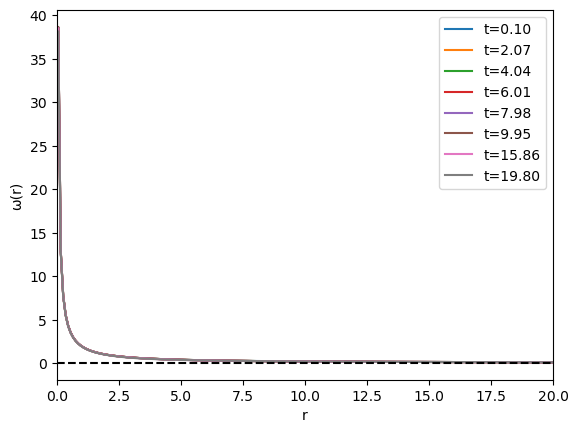

 Nessun buco nero: ω(r) è sempre >= 0 (campo disperso).


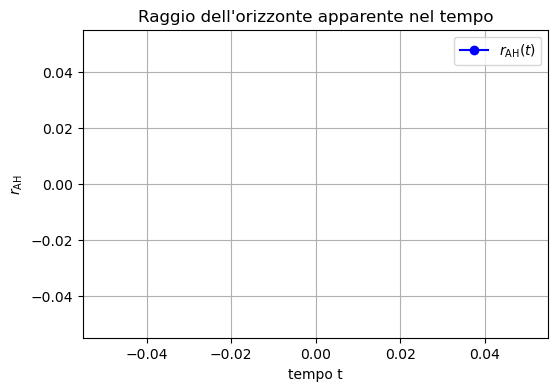

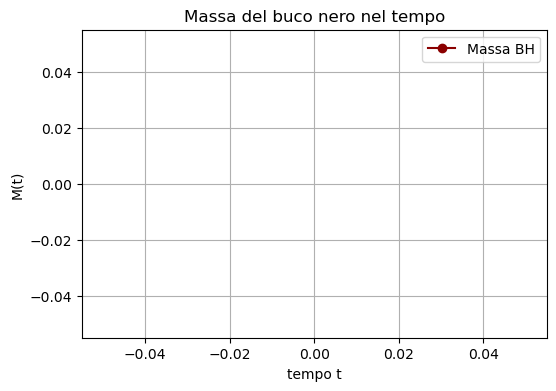

ah_radius min/max: 0.0 0.0
bh_masss min/max: 0.0 0.0


In [8]:
# Calcola l'area dell'AH direttamente dal raggio areale
omega, ah_radius, bh_mass = get_horizon_diagnostics(solution, t, grid, bg, matter)

# Plot di ω(r) a tempi selezionati
for i in [0, 10, 20, 30, 40, 50, 80, 100]:
    plt.plot(r, omega[i], label=f"t={t[i]:.2f}")

plt.axhline(0, color="k", linestyle="--")
plt.xlabel("r")
plt.ylabel("ω(r)")
plt.legend()
plt.xlim(0.0,20.0)
#plt.ylim(-1,1)
plt.show()



# --- Diagnostica ---
if np.any(omega < 0):
    print(" Buco nero formato: esiste un raggio con ω(r) < 0 (orizzonte apparente).")
else:
    print(" Nessun buco nero: ω(r) è sempre >= 0 (campo disperso).")

# --- Plot del raggio AH ---
mask = ah_radius > 0   # usa solo i tempi in cui l'orizzonte è stato trovato
plt.figure(figsize=(6,4))
plt.plot(t[mask], ah_radius[mask], "o-", color="blue", label=r"$r_{\rm AH}(t)$")
plt.xlabel("tempo t")
plt.ylabel(r"$r_{\rm AH}$")
plt.title("Raggio dell'orizzonte apparente nel tempo")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot della massa BH ---
mask = bh_mass > 0
plt.figure(figsize=(6,4))
plt.plot(t[mask], bh_mass[mask], "o-", color="darkred", label="Massa BH")
plt.xlabel("tempo t")
plt.ylabel("M(t)")
plt.title("Massa del buco nero nel tempo")
plt.grid(True)
plt.legend()
plt.show()




print("ah_radius min/max:", ah_radius.min(), ah_radius.max()) 
print("bh_masss min/max:", bh_mass.min(), bh_mass.max())


In [9]:
# calculate the diagnostics, just the Hamiltonian constraint for now
Ham, Mom = get_constraints_diagnostic(solution, t, grid, bg, matter)

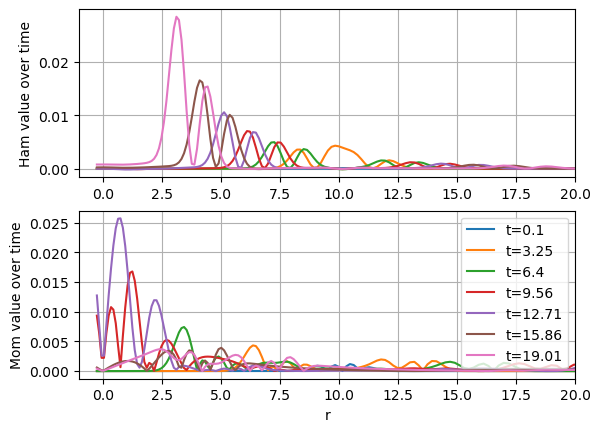

In [10]:
# plot the profile for Ham and Mom at a selection of times

for i, t_i in enumerate(t) :
    if (i < num_points_t) and (i % 16 == 0) :
        labelt = "t="+str(round(t_i,2))
        Ham_t = Ham[i,:]
        ax1 = plt.subplot(211)
        plt.plot(r, Ham_t, label=labelt)
        ax2 = plt.subplot(212)
        Mom_t = np.sqrt(Mom[i,:,i_r]**2 + Mom[i,:,i_t]**2 + Mom[i,:,i_p]**2)
        plt.plot(r, Mom_t, label=labelt)

plt.legend()
ax2.set_xlabel('r')
ax1.set_ylabel('Ham value over time')
ax1.set_xlim(-1,20.0)
#ax1.set_ylim(-5e-5,5e-5)
ax1.grid()
ax2.set_ylabel('Mom value over time')
ax2.set_xlim(-1,20.0)
#ax2.set_ylim(-5e-5,5e-5)
ax2.grid();
plt.show()